In [118]:
import pandas as pd
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
import contextily as ctx
import requests
from shapely.geometry import Point, Polygon
from datetime import datetime
from tqdm import tqdm
import time
from collections import defaultdict
import seaborn as sns
from prophet import Prophet
from scipy.optimize import curve_fit
import numpy as n
from scipy.interpolate import CubicSpline
import itertools
from prophet.diagnostics import cross_validation, performance_metrics
import pickle
from scipy.stats import linregress
import numpy as np
from sklearn.cluster import KMeans
from pykrige.ok import OrdinaryKriging
from pyproj import Transformer

In [2]:
central = pd.read_csv("../data/central_stations_observations.csv")

In [3]:
central["min_2014_2024"] = central[[f'observations_{year}' for year in range(2014, 2025)]].min(axis=1)

In [87]:
central_ov25 = central[central.min_2014_2024 > 25].copy()

In [5]:
def fetch_all_records(site_code, year):
    all_records = []
    offset = 0
    limit = 1000
    while True:
        url = f"https://data.cnra.ca.gov/api/3/action/datastore_search?resource_id=bfa9f262-24a1-45bd-8dc8-138bc8107266&q={site_code} {year}&limit={limit}&offset={offset}"
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            records = data['result']['records']
            all_records.extend(records)
            if len(records) < limit:
                break
            offset += limit
        else:
            print(f"Failed to fetch data for {site_code} in {year}")
            break
    return all_records

def get_readings_for_site(site_code, years):
    all_readings = []
    for year in tqdm(years, desc=f"Fetching data for {site_code}"):
        records = fetch_all_records(site_code, year)
        for record in records:
            reading = {
                'site_code': record.get('site_code'),
                'msmt_date': record.get('msmt_date'),
                'wlm_rpe': record.get('wlm_rpe'),
                'wlm_gse': record.get('wlm_gse'),
                'gwe': record.get('gwe')
            }
            all_readings.append(reading)
    return pd.DataFrame(all_readings)

In [6]:
def interpolate_gwe(site_code, years, readings_df):
    site_data = readings_df
    site_data.rename(columns={"msmt_date": "ds", "gwe": "y"}, inplace=True)
    site_data['ds'] = pd.to_datetime(site_data['ds'])

    full_date_range = pd.date_range(start=f"{min(years)}-01-01", end=f"{max(years)}-12-31", freq="D")
    full_df = pd.DataFrame({'ds': full_date_range})
    full_df = full_df.merge(site_data, on='ds', how='left')

    m = Prophet(
        changepoint_prior_scale=0.05,
        seasonality_prior_scale=0.1,
        yearly_seasonality=True
    )
    m.fit(site_data.dropna())

    forecast = m.predict(full_df)

    full_df['y_interpolated'] = forecast['yhat']

    result_df = full_df[['ds', 'y_interpolated']].copy()
    result_df.rename(columns={"ds": "date", "y_interpolated": "gwe_interpolated"}, inplace=True)

    return result_df

In [7]:
def gwe_10y(site_code, start_yr):
    years = [start_yr + i for i in range(0, 11)]
    readings_df = get_readings_for_site(site_code, years)
    predicted = interpolate_gwe(site_code, years, readings_df)

    predicted['date'] = pd.to_datetime(predicted['date'])
    predicted.set_index('date', inplace=True)

    monthly_avg = predicted.resample('ME').mean()
    
    return monthly_avg

In [8]:
well_gwe_monthly = pd.read_pickle("../data/well_gwe_monthly.pkl")

In [21]:
def get_precipitation_data(latitude, longitude, start_date, end_date, parameter="PRECTOTCORR"):
    base_url = "https://power.larc.nasa.gov/api/temporal/daily/point"
    
    params = {
        "parameters": parameter,
        "community": "AG",
        "longitude": longitude,
        "latitude": latitude,
        "start": start_date,
        "end": end_date,
        "format": "JSON"
    }

    response = requests.get(base_url, params=params)
    response.raise_for_status()

    data = response.json()

    try:
        precip_data = data["properties"]["parameter"][parameter]
    except KeyError as e:
        raise ValueError(f"Unable to retrieve parameter '{parameter}' from response: {e}")

    return precip_data

In [10]:
well_gwe_monthly.get("404614N1222443W001")

gwe_interpolated
date                        
2014-01-31        380.663687
2014-02-28        381.782082
2014-03-31        381.805231
2014-04-30        381.870860
2014-05-31        382.607756
...                      ...
2024-08-31        385.727453
2024-09-30        385.536266
2024-10-31        385.620144
2024-11-30        385.410308
2024-12-31        385.763634

[132 rows x 1 columns]

In [17]:
def calculate_groundwater_changes(data_dict):
    result_dict = {}
    for year in range(2014, 2024):
        year_dict = {}

        for site_code, df in data_dict.items():
            try:
                october_value = df.loc[f'{year}-10-31'].iloc[0]
                september_value = df.loc[f'{year+1}-09-30'].iloc[0]
                change = october_value - september_value
                year_dict[site_code] = change
            except KeyError:
                print(f"Warning: Missing data for site {site_code} in year {year} or {year+1}.")
                year_dict[site_code] = None

        result_dict[year] = year_dict

    return result_dict

In [18]:
changes = calculate_groundwater_changes(well_gwe_monthly)

In [20]:
central_ov25.head()

site_code  latitude  longitude  well_depth     well_use  \
3750  384159N1217303W001  38.41590 -121.73030        43.0  Observation   
3751  384159N1217303W002  38.41585 -121.73034       243.0  Observation   
3752  384159N1217303W003  38.41590 -121.73030       445.0  Observation   
4014  386062N1215602W001  38.60620 -121.56020       100.0  Observation   
4015  386062N1215602W002  38.60620 -121.56020       170.0  Observation   

     geology Region_Off Basin_Subb  observations_2010  observations_2011  ...  \
3750   ['Q']       NCRO   5-021.66                391                384  ...   
3751   ['Q']       NCRO   5-021.66                306                358  ...   
3752   ['Q']       NCRO   5-021.66                364                384  ...   
4014   ['Q']       NCRO   5-021.67                  2                  0  ...   
4015   ['Q']       NCRO   5-021.67                  2                  0  ...   

      observations_2016  observations_2017  observations_2018  \
3750                325                385                381   
3751                382                385                381   
3752                382                385                381   
4014                289                299                164   
4015                261                299                310   

      observations_2019  observations_2020  observations_2021  \
3750                292                380                384   
3751                292                380                384   
3752                292                380                384   
4014                371                370                372   
4015                369                370                372   

      observations_2022  observations_2023  observations_2024  min_2014_2024  
3750                384                378                257            229  
3751                384                269                197            197  
3752                384                378                197            112  
4014                370                361                324            164  
4015                370                365                324            216  

[5 rows x 24 columns]

In [30]:
def process_precipitation_data(precip_data):
    df = pd.DataFrame.from_dict(precip_data, orient="index", columns=["precipitation"])
    df.index = pd.to_datetime(df.index)
    monthly_avg = df.resample("ME").mean()
    
    return monthly_avg

def get_monthly_precipitation_for_sites(central_ov25, start_date=2014, end_date=2024):
    result_dict = {}

    for index, row in tqdm(central_ov25.iterrows(), total=len(central_ov25), desc="Processing sites"):
        site_code = row["site_code"]
        latitude = row["latitude"]
        longitude = row["longitude"]

        try:
            precip_data = get_precipitation_data(latitude, longitude, start_date, end_date)
            monthly_avg = process_precipitation_data(precip_data)
            result_dict[site_code] = monthly_avg

        except Exception as e:
            print(f"Error processing site {site_code}: {e}")
            result_dict[site_code] = None

    return result_dict

In [31]:
precipitation_data = get_monthly_precipitation_for_sites(central_ov25)

Processing sites: 100%|███████████████████████| 298/298 [08:18<00:00,  1.67s/it]


In [32]:
precipitation_data.get("384159N1217303W001")

precipitation
2014-01-31       0.213871
2014-02-28       5.565714
2014-03-31       2.186129
2014-04-30       1.225667
2014-05-31       0.068710
...                   ...
2024-08-31       0.041935
2024-09-30       0.001667
2024-10-31       0.216129
2024-11-30       7.461333
2024-12-31       5.642903

[132 rows x 1 columns]

In [33]:
def calculate_annual_precipitation_averages(precipitation_dict):
    """
    Calculate the average precipitation between October (year 0) and September (year 1)
    for each site and year.

    Parameters:
        precipitation_dict (dict): A dictionary mapping site_code to DataFrames of monthly
                                  average precipitation.

    Returns:
        dict: A nested dictionary where the keys are years (year 0) and the values are
              dictionaries mapping site_code to the average precipitation for the period
              October (year 0) to September (year 1).
    """
    # Initialize the result dictionary
    result_dict = {}

    # Iterate through each year from 2014 to 2023
    for year in range(2014, 2024):
        # Initialize a dictionary to store the averages for this year
        year_dict = {}

        # Iterate through each site and its corresponding DataFrame
        for site_code, monthly_avg in precipitation_dict.items():
            if monthly_avg is not None:  # Skip sites with missing data
                try:
                    # Extract the period from October (year 0) to September (year 1)
                    start_date = f"{year}-10-31"
                    end_date = f"{year+1}-09-30"
                    period_data = monthly_avg.loc[start_date:end_date]

                    # Calculate the average precipitation for the period
                    average_precip = period_data["precipitation"].mean()

                    # Store the average in the year_dict
                    year_dict[site_code] = average_precip
                except KeyError:
                    # Handle missing data for the period
                    print(f"Warning: Missing data for site {site_code} in year {year}.")
                    year_dict[site_code] = None

        # Store the year_dict in the result_dict
        result_dict[year] = year_dict

    return result_dict

In [36]:
well_precipitation = calculate_annual_precipitation_averages(precipitation_data)

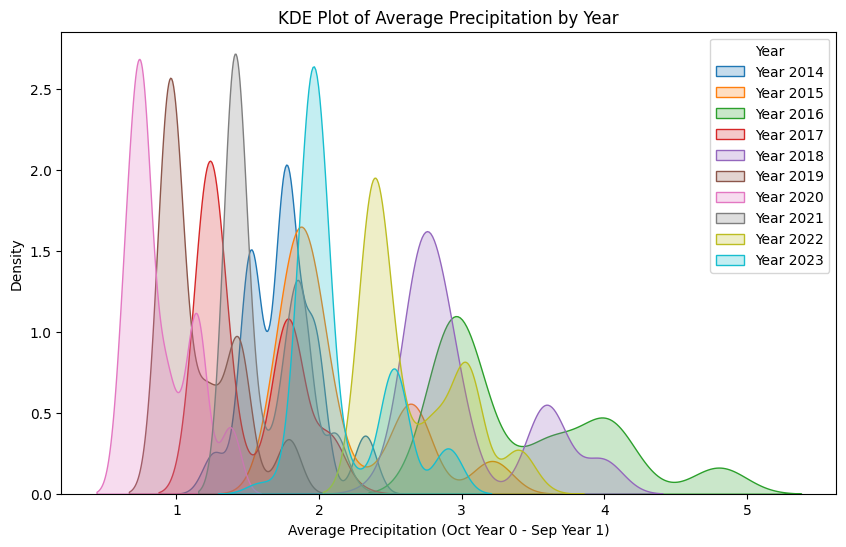

In [37]:
data = []
for year, site_data in well_precipitation.items():
    for site_code, avg_precip in site_data.items():
        data.append({"year": year, "site_code": site_code, "average_precipitation": avg_precip})

df = pd.DataFrame(data)

# Plot KDEs for each year
plt.figure(figsize=(10, 6))
for year in df["year"].unique():
    sns.kdeplot(
        df[df["year"] == year]["average_precipitation"],
        label=f"Year {year}",
        fill=True
    )

# Add labels and title
plt.xlabel("Average Precipitation (Oct Year 0 - Sep Year 1)")
plt.ylabel("Density")
plt.title("KDE Plot of Average Precipitation by Year")
plt.legend(title="Year")

# Show the plot
plt.show()

In [41]:
def filter_middle_95_by_year(df):
    filtered_data = []
    for year, group in df.groupby("year"):
        lower_threshold = np.percentile(group["average_precipitation"], 2.5)
        upper_threshold = np.percentile(group["average_precipitation"], 97.5)
        filtered_group = group[
            (group["average_precipitation"] >= lower_threshold) &
            (group["average_precipitation"] <= upper_threshold)
        ]
        filtered_data.append(filtered_group)
    return pd.concat(filtered_data)

In [48]:
filtered_rain = filter_middle_95_by_year(df)

In [51]:
filtered_rain.head()

year           site_code  average_precipitation
0  2014  384159N1217303W001               1.276127
1  2014  384159N1217303W002               1.276127
2  2014  384159N1217303W003               1.276127
5  2014  386464N1216675W002               1.276127
6  2014  386464N1216675W003               1.276127

In [55]:
precip_year_stats = filtered_rain[["year", "average_precipitation"]].groupby("year").agg(
    mean_precipitation=('average_precipitation', 'mean'),
    variance_precipitation=('average_precipitation', 'var')
)

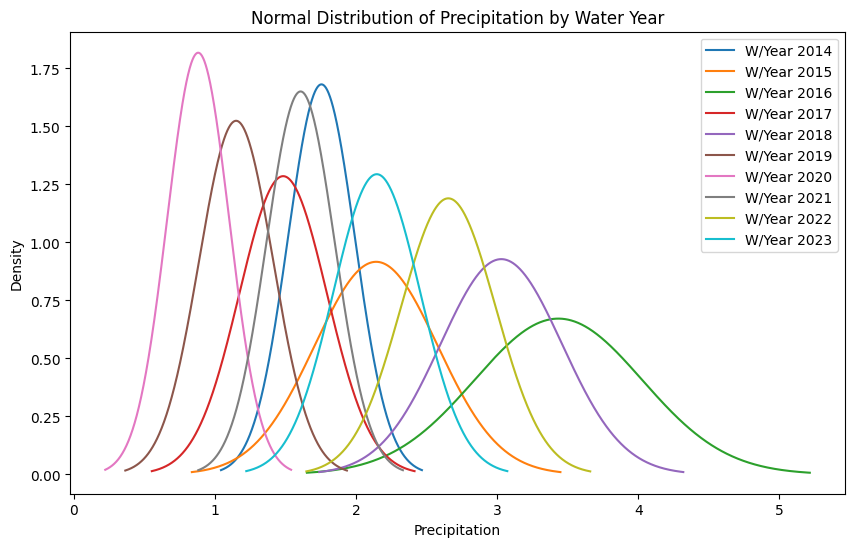

In [63]:
plt.figure(figsize=(10, 6))

for year, row in precip_year_stats.iterrows():
    mean = row['mean_precipitation']
    variance = row['variance_precipitation']
    std_dev = np.sqrt(variance)
    x = np.linspace(mean - 3 * std_dev, mean + 3 * std_dev, 1000)
    y = (1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std_dev) ** 2)
    sns.lineplot(x=x, y=y, label=f'W/Year {year}')

plt.xlabel('Precipitation')
plt.ylabel('Density')
plt.title('Normal Distribution of Precipitation by Water Year')
plt.legend()
plt.show()

In [59]:
precip_year_stats["wet/dry"] = np.where(precip_year_stats['mean_precipitation'] > 2, 'wet', 'dry')

In [60]:
precip_year_stats

mean_precipitation  variance_precipitation wet/dry
year                                                    
2014            1.754826                0.056295     dry
2015            2.142250                0.189446     wet
2016            3.433437                0.352716     wet
2017            1.483571                0.096272     dry
2018            3.029112                0.184773     wet
2019            1.150101                0.068488     dry
2020            0.881286                0.048165     dry
2021            1.606905                0.058399     dry
2022            2.653636                0.112359     wet
2023            2.146913                0.095021     wet

In [88]:
wet_years = precip_year_stats[precip_year_stats['wet/dry'] == 'wet'].index.tolist()
dry_years = precip_year_stats[precip_year_stats['wet/dry'] == 'dry'].index.tolist()

# Step 2: Initialize dictionaries to store the sum and count of GWE changes for wet and dry years
wet_gwe_sum = {}
dry_gwe_sum = {}
wet_gwe_count = {}
dry_gwe_count = {}

# Step 3: Iterate over the dictionary and filter changes for wet and dry years
for year, site_changes in changes.items():
    if year in wet_years:
        for site_code, change in site_changes.items():
            if site_code in wet_gwe_sum:
                wet_gwe_sum[site_code] += change
                wet_gwe_count[site_code] += 1
            else:
                wet_gwe_sum[site_code] = change
                wet_gwe_count[site_code] = 1
    elif year in dry_years:
        for site_code, change in site_changes.items():
            if site_code in dry_gwe_sum:
                dry_gwe_sum[site_code] += change
                dry_gwe_count[site_code] += 1
            else:
                dry_gwe_sum[site_code] = change
                dry_gwe_count[site_code] = 1

# Step 4: Calculate the average changes in GWE for each site_code
wet_gwe_avg = {site_code: wet_gwe_sum[site_code] / wet_gwe_count[site_code] for site_code in wet_gwe_sum}
dry_gwe_avg = {site_code: dry_gwe_sum[site_code] / dry_gwe_count[site_code] for site_code in dry_gwe_sum}

# Step 5: Add the calculated averages as new columns in central_ov25
central_ov25['wet_avg_gwe'] = central_ov25['site_code'].map(wet_gwe_avg)
central_ov25['dry_avg_gwe'] = central_ov25['site_code'].map(dry_gwe_avg)

In [90]:
central_ov25.describe()

latitude   longitude   well_depth  observations_2010  \
count  298.000000  298.000000   298.000000         298.000000   
mean    39.465001 -121.857009   430.204698         250.211409   
std      0.469736    0.336123   320.703533         138.669115   
min     38.415850 -122.333850     7.000000           0.000000   
25%     39.024430 -122.102000   173.500000         136.000000   
50%     39.554545 -121.913900   326.000000         299.500000   
75%     39.783560 -121.655050   668.500000         368.000000   
max     40.470520 -120.471740  1350.000000         391.000000   

       observations_2011  observations_2012  observations_2013  \
count         298.000000         298.000000         298.000000   
mean          302.204698         336.912752         347.543624   
std           117.207700          83.386321          57.841125   
min             0.000000           0.000000           3.000000   
25%           276.000000         364.000000         363.250000   
50%           367.000000         368.000000         368.000000   
75%           370.000000         370.000000         373.000000   
max           384.000000         379.000000         393.000000   

       observations_2014  observations_2015  observations_2016  ...  \
count         298.000000         298.000000         298.000000  ...   
mean          331.442953         323.828859         318.500000  ...   
std            89.137270          91.045226          93.330059  ...   
min            28.000000          37.000000          31.000000  ...   
25%           365.000000         297.000000         296.000000  ...   
50%           368.000000         368.000000         367.000000  ...   
75%           371.000000         371.750000         371.000000  ...   
max           400.000000         425.000000         425.000000  ...   

       observations_2018  observations_2019  observations_2020  \
count         298.000000         298.000000         298.000000   
mean          329.251678         334.590604         325.016779   
std            87.260439          79.297336          94.596768   
min            47.000000          45.000000          51.000000   
25%           335.500000         356.000000         331.000000   
50%           368.000000         368.000000         369.000000   
75%           370.000000         368.000000         370.000000   
max           425.000000         423.000000         429.000000   

       observations_2021  observations_2022  observations_2023  \
count         298.000000         298.000000         298.000000   
mean          340.382550         333.278523         328.657718   
std            92.696935         113.847495          83.667554   
min            52.000000          52.000000          51.000000   
25%           322.250000         320.000000         319.250000   
50%           368.000000         368.000000         367.000000   
75%           373.000000         373.000000         369.000000   
max           488.000000         756.000000         380.000000   

       observations_2024  min_2014_2024  wet_avg_gwe  dry_avg_gwe  
count         298.000000     298.000000   298.000000   298.000000  
mean          283.949664     199.120805    -1.875939     5.484235  
std            86.896011      91.620459     3.953778     5.766752  
min            46.000000      28.000000   -20.903848   -16.649131  
25%           251.000000     128.750000    -3.350117     1.658202  
50%           299.000000     197.500000    -1.639954     4.440550  
75%           347.500000     285.000000    -0.115238     8.367428  
max           382.000000     368.000000    17.790886    25.516934  

[8 rows x 21 columns]

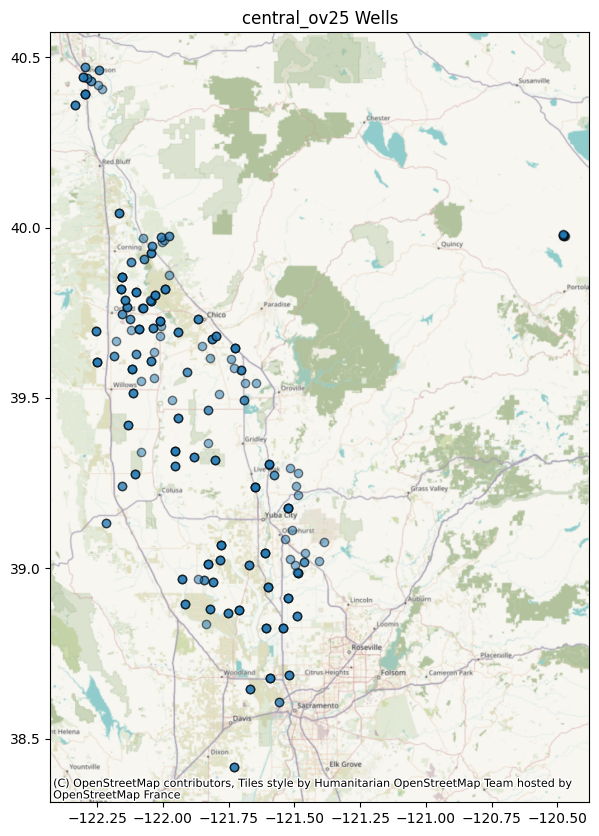

In [67]:
gdf = gpd.GeoDataFrame(central_ov25, geometry=gpd.points_from_xy(central_ov25.longitude, central_ov25.latitude))
gdf.set_crs(epsg=4326, inplace=True)

ax = gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax, crs=gdf.crs.to_string())

plt.title('central_ov25 Wells')
plt.show()

In [68]:
central_ov25.Region_Off.value_counts()

Region_Off
NRO     199
NCRO     99
Name: count, dtype: int64

In [69]:
SGMA = "../data/GWBasins.shp"
gdf = gpd.read_file(SGMA)
gdf.set_crs(epsg=3857, inplace=True)
gdf.set_index('OBJECTID', inplace=True)
gdf['Basin_Prefix'] = gdf['Basin_Numb'].str.split('-').str[0].astype(int)

In [91]:
central_ov25_5021 = central_ov25[central_ov25.Basin_Subb.str.startswith("5-021")].copy()

In [92]:
central_ov25_5021

site_code  latitude  longitude  well_depth     well_use  \
3750  384159N1217303W001  38.41590 -121.73030        43.0  Observation   
3751  384159N1217303W002  38.41585 -121.73034       243.0  Observation   
3752  384159N1217303W003  38.41590 -121.73030       445.0  Observation   
4014  386062N1215602W001  38.60620 -121.56020       100.0  Observation   
4015  386062N1215602W002  38.60620 -121.56020       170.0  Observation   
...                  ...       ...        ...         ...          ...   
5753  399740N1219748W001  39.97397 -121.97484       263.0  Observation   
5754  399740N1219748W002  39.97397 -121.97484       743.0  Observation   
5794  400428N1221665W001  40.04281 -122.16651       255.0  Observation   
5795  400428N1221665W002  40.04281 -122.16651       789.0  Observation   
5796  400428N1221665W003  40.04281 -122.16651      1000.0  Observation   

      geology Region_Off Basin_Subb  observations_2010  observations_2011  \
3750    ['Q']       NCRO   5-021.66                391                384   
3751    ['Q']       NCRO   5-021.66                306                358   
3752    ['Q']       NCRO   5-021.66                364                384   
4014    ['Q']       NCRO   5-021.67                  2                  0   
4015    ['Q']       NCRO   5-021.67                  2                  0   
...       ...        ...        ...                ...                ...   
5753  ['QPc']        NRO   5-021.56                368                369   
5754  ['QPc']        NRO   5-021.56                  3                152   
5794    ['Q']        NRO   5-021.50                367                368   
5795    ['Q']        NRO   5-021.50                302                 15   
5796    ['Q']        NRO   5-021.50                367                369   

      ...  observations_2018  observations_2019  observations_2020  \
3750  ...                381                292                380   
3751  ...                381                292                380   
3752  ...                381                292                380   
4014  ...                164                371                370   
4015  ...                310                369                370   
...   ...                ...                ...                ...   
5753  ...                368                366                219   
5754  ...                368                366                369   
5794  ...                369                368                105   
5795  ...                369                368                195   
5796  ...                364                290                145   

      observations_2021  observations_2022  observations_2023  \
3750                384                384                378   
3751                384                384                269   
3752                384                384                378   
4014                372                370                361   
4015                372                370                365   
...                 ...                ...                ...   
5753                368                368                368   
5754                311                368                368   
5794                251                371                372   
5795                266                371                372   
5796                291                369                370   

      observations_2024  min_2014_2024  wet_avg_gwe  dry_avg_gwe  
3750                257            229    -1.736250     1.832607  
3751                197            197     5.183161     8.165051  
3752                197            112    12.889593    14.796562  
4014                324            164    -2.416431    -2.257576  
4015                324            216    -2.084139    -1.408053  
...                 ...            ...          ...          ...  
5753                295            219     0.005596     1.255562  
5754                273            273    -

/var/folders/cm/7q16kyx93zs34t0y4j49dt000000gn/T/ipykernel_88320/1198535527.py:26: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


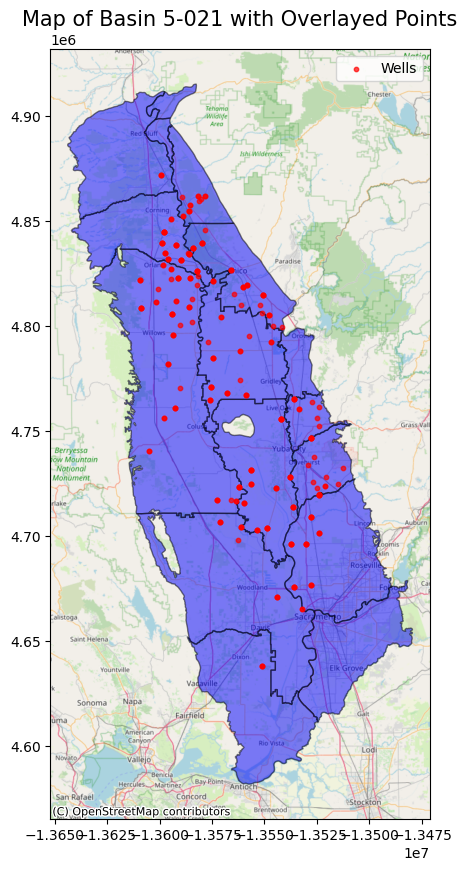

In [78]:
filtered_gdf = gdf[gdf['Basin_Numb'] == '5-021']

if filtered_gdf.crs is None:
    filtered_gdf.set_crs(epsg=4326, inplace=True)

filtered_gdf = filtered_gdf.to_crs(epsg=3857)

points_gdf = gpd.GeoDataFrame(
    central_ov25_5021,
    geometry=gpd.points_from_xy(central_ov25_5021['longitude'], central_ov25_5021['latitude'])
)

points_gdf.set_crs(epsg=4326, inplace=True)

points_gdf = points_gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 10))

filtered_gdf.plot(ax=ax, color='blue', edgecolor='black', alpha=0.5, label='Basin 5-021')

points_gdf.plot(ax=ax, marker='o', color='red', markersize=10, alpha=0.7, label='Wells')

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_title('Map of Basin 5-021 with Overlayed Points', fontsize=15)
ax.legend()

plt.show()

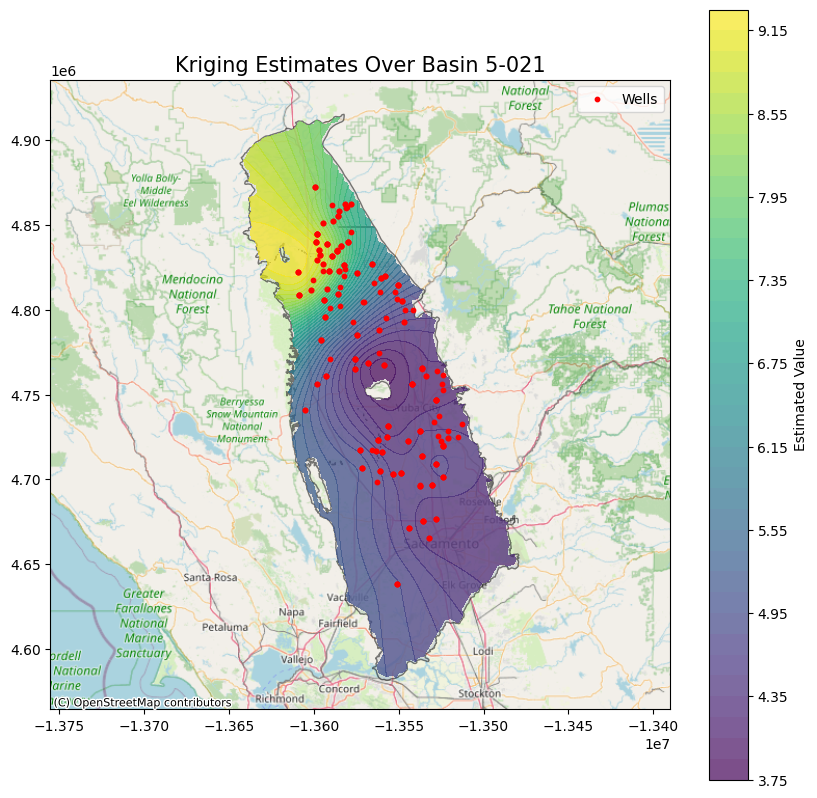

In [119]:
filtered_gdf = gdf[gdf['Basin_Numb'] == '5-021']

larger_polygon = filtered_gdf.dissolve().geometry.iloc[0]
larger_polygon_gdf = gpd.GeoDataFrame(geometry=[larger_polygon], crs=filtered_gdf.crs)
larger_polygon_gdf = larger_polygon_gdf.to_crs(epsg=32633)

bounds = larger_polygon_gdf.total_bounds

wells_gdf = gpd.GeoDataFrame(
    central_ov25_5021,
    geometry=gpd.points_from_xy(
        central_ov25_5021['longitude'], 
        central_ov25_5021['latitude']
    )
)

wells_gdf.set_crs(epsg=4326, inplace=True)
wells_gdf = wells_gdf.to_crs(larger_polygon_gdf.crs)

x = wells_gdf.geometry.x
y = wells_gdf.geometry.y
z = wells_gdf['dry_avg_gwe']  

grid_x = np.linspace(bounds[0], bounds[2], num=100)
grid_y = np.linspace(bounds[1], bounds[3], num=100)

ok = OrdinaryKriging(
    x, 
    y, 
    z, 
    variogram_model='linear'  # You can try 'spherical', 'exponential', etc.
)
z_interp, ss = ok.execute('grid', grid_x, grid_y)

xx, yy = np.meshgrid(grid_x, grid_y)

grid_points = np.vstack((xx.flatten(), yy.flatten())).T
grid_points_gdf = gpd.GeoSeries(
    gpd.points_from_xy(grid_points[:, 0], grid_points[:, 1]), 
    crs=larger_polygon_gdf.crs
)

mask = grid_points_gdf.within(larger_polygon_gdf.geometry.iloc[0])
mask = mask.values.reshape(xx.shape)
z_interp_masked = np.ma.masked_where(~mask, z_interp)

larger_polygon_3857 = larger_polygon_gdf.to_crs(epsg=3857)
wells_gdf_3857 = wells_gdf.to_crs(epsg=3857)

transformer = Transformer.from_crs("EPSG:32633", "EPSG:3857", always_xy=True)
xx_3857, yy_3857 = transformer.transform(xx, yy)

fig, ax = plt.subplots(figsize=(10, 10))
larger_polygon_3857.plot(
    ax=ax, 
    color='lightgray', 
    edgecolor='black', 
    alpha=0.5
)

contour = ax.contourf(
    xx_3857, 
    yy_3857, 
    z_interp_masked, 
    levels=50, 
    cmap='viridis', 
    alpha=0.7
)

wells_gdf_3857.plot(
    ax=ax, 
    marker='o', 
    color='red', 
    markersize=10, 
    label='Wells'
)

cbar = plt.colorbar(contour, ax=ax)
cbar.set_label('Estimated Value')

ax.set_title('Kriging Estimates Over Basin 5-021', fontsize=15)
ax.legend()

ax.set_aspect('equal')

ctx.add_basemap(
    ax, 
    crs=larger_polygon_3857.crs,
    source=ctx.providers.OpenStreetMap.Mapnik
)

plt.show()


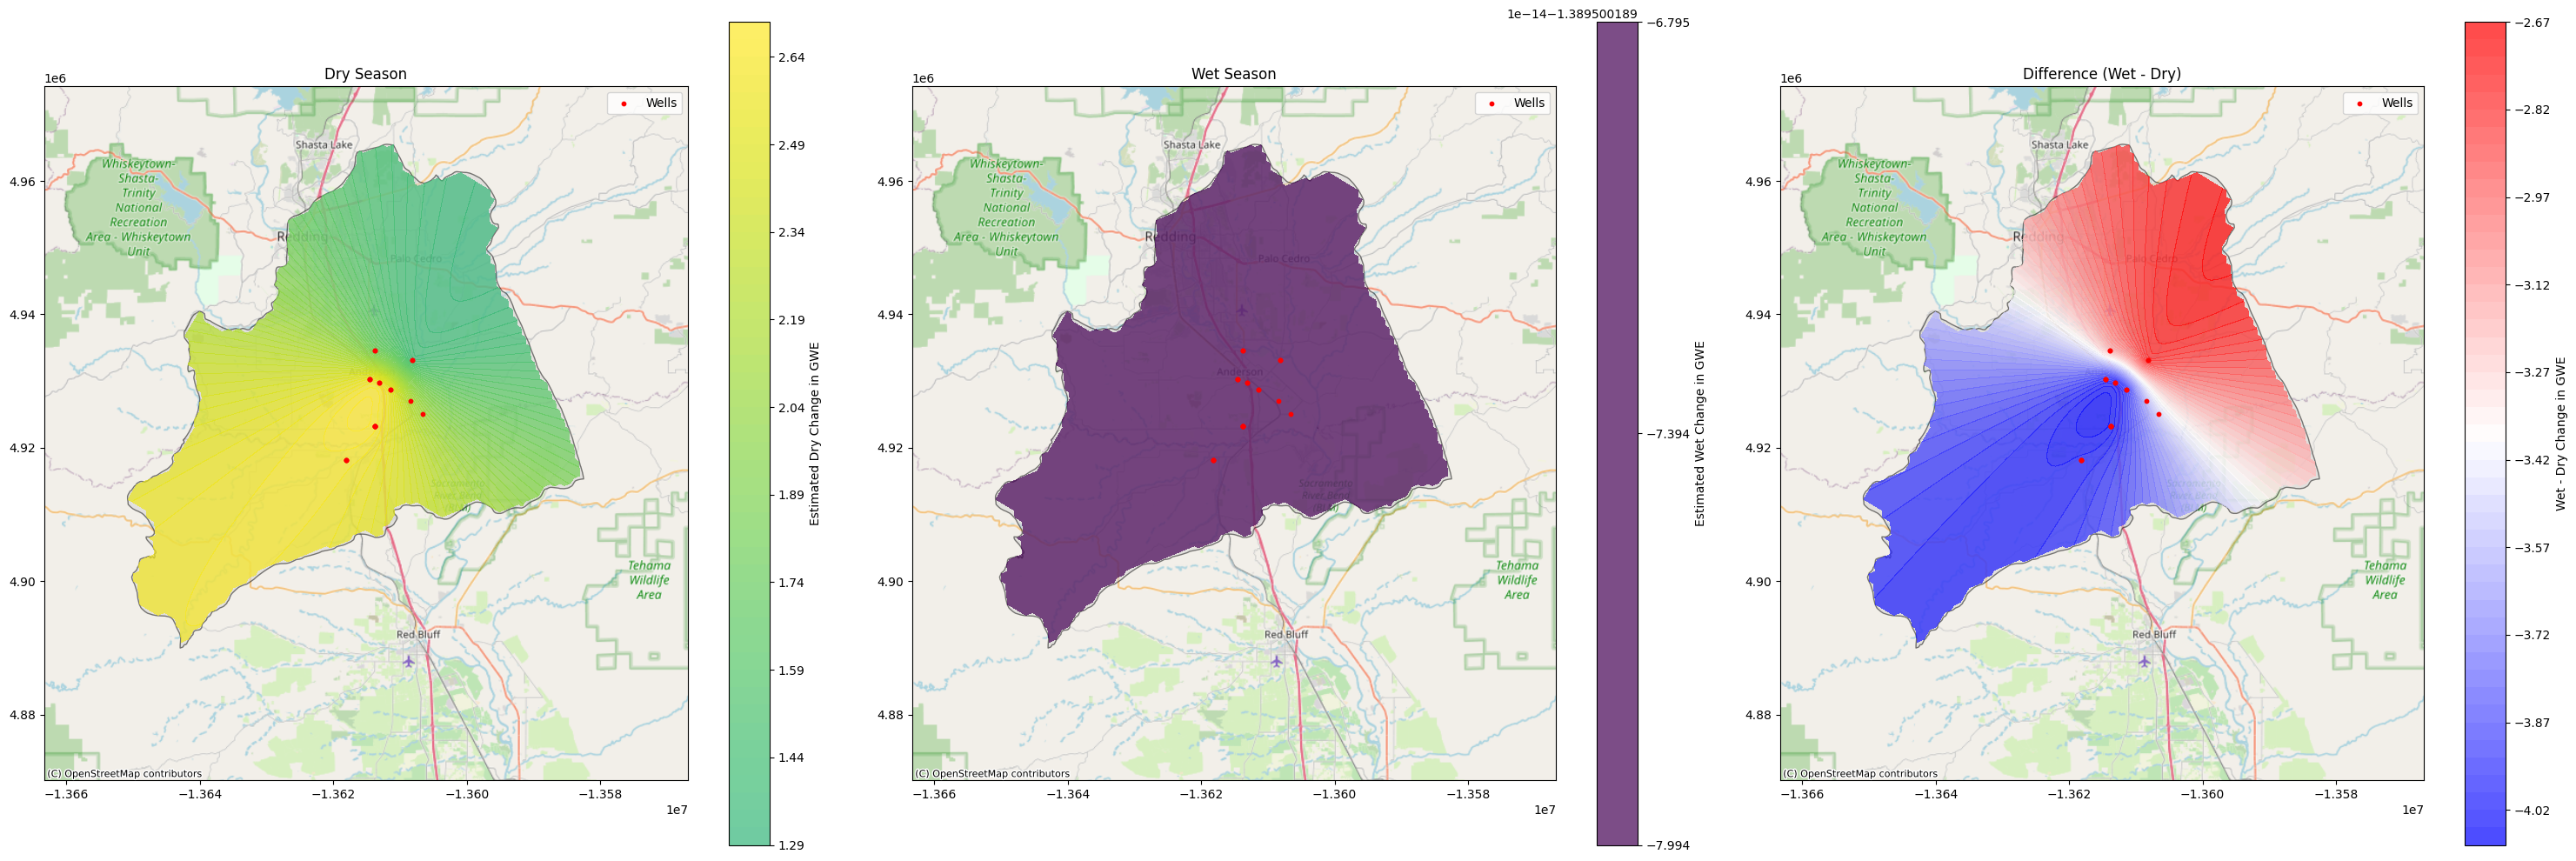

In [132]:
filtered_gdf = gdf[gdf['Basin_Numb'] == '5-006']
larger_polygon = filtered_gdf.dissolve().geometry.iloc[0]

larger_polygon_gdf = gpd.GeoDataFrame(geometry=[larger_polygon], crs=filtered_gdf.crs)

larger_polygon_gdf = larger_polygon_gdf.to_crs(epsg=32633)
bounds = larger_polygon_gdf.total_bounds

wells_gdf = gpd.GeoDataFrame(
    central_ov25[central_ov25.Basin_Subb.str.startswith("5-006")],
    geometry=gpd.points_from_xy(
        central_ov25[central_ov25.Basin_Subb.str.startswith("5-006")]['longitude'], 
        central_ov25[central_ov25.Basin_Subb.str.startswith("5-006")]['latitude']
    ),
    crs="EPSG:4326"
)
wells_gdf = wells_gdf.to_crs(larger_polygon_gdf.crs)

x = wells_gdf.geometry.x
y = wells_gdf.geometry.y

z_dry = wells_gdf['dry_avg_gwe']
z_wet = wells_gdf['wet_avg_gwe']

grid_x = np.linspace(bounds[0], bounds[2], num=100)
grid_y = np.linspace(bounds[1], bounds[3], num=100)

ok_dry = OrdinaryKriging(x, y, z_dry, variogram_model='linear')
z_interp_dry, ss_dry = ok_dry.execute('grid', grid_x, grid_y)

ok_wet = OrdinaryKriging(x, y, z_wet, variogram_model='linear')
z_interp_wet, ss_wet = ok_wet.execute('grid', grid_x, grid_y)

xx, yy = np.meshgrid(grid_x, grid_y)

grid_points = np.vstack((xx.flatten(), yy.flatten())).T
grid_points_gdf = gpd.GeoSeries(
    gpd.points_from_xy(grid_points[:, 0], grid_points[:, 1]),
    crs=larger_polygon_gdf.crs
)
mask = grid_points_gdf.within(larger_polygon_gdf.geometry.iloc[0])
mask = mask.values.reshape(xx.shape)

z_interp_masked_dry = np.ma.masked_where(~mask, z_interp_dry)
z_interp_masked_wet = np.ma.masked_where(~mask, z_interp_wet)

z_interp_diff = z_interp_wet - z_interp_dry
z_interp_masked_diff = np.ma.masked_where(~mask, z_interp_diff)

dry_values = z_interp_masked_dry.compressed()
wet_values = z_interp_masked_wet.compressed()
diff_values = z_interp_masked_diff.compressed()

wetdry_min = min(dry_values.min(), wet_values.min())
wetdry_max = max(dry_values.max(), wet_values.max())

diff_min, diff_max = diff_values.min(), diff_values.max()

larger_polygon_3857 = larger_polygon_gdf.to_crs(epsg=3857)
wells_gdf_3857 = wells_gdf.to_crs(epsg=3857)

transformer = Transformer.from_crs("EPSG:32633", "EPSG:3857", always_xy=True)
xx_3857, yy_3857 = transformer.transform(xx, yy)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(30, 10))

larger_polygon_3857.plot(ax=ax1, color='lightgray', edgecolor='black', alpha=0.5)

contour_dry = ax1.contourf(
    xx_3857, yy_3857,
    z_interp_masked_dry,
    levels=50,
    cmap='viridis',
    alpha=0.7,
    vmin=wetdry_min,
    vmax=wetdry_max
)

wells_gdf_3857.plot(ax=ax1, marker='o', color='red', markersize=10, label='Wells')

cbar_dry = plt.colorbar(contour_dry, ax=ax1)
cbar_dry.set_label('Estimated Dry Change in GWE')
ax1.set_title('Dry Season')
ax1.set_aspect('equal')
ax1.legend()

ctx.add_basemap(ax1, crs=larger_polygon_3857.crs, source=ctx.providers.OpenStreetMap.Mapnik)

larger_polygon_3857.plot(ax=ax2, color='lightgray', edgecolor='black', alpha=0.5)

contour_wet = ax2.contourf(
    xx_3857, yy_3857,
    z_interp_masked_wet,
    levels=50,
    cmap='viridis',
    alpha=0.7,
    vmin=wetdry_min,
    vmax=wetdry_max
)

wells_gdf_3857.plot(ax=ax2, marker='o', color='red', markersize=10, label='Wells')

cbar_wet = plt.colorbar(contour_wet, ax=ax2)
cbar_wet.set_label('Estimated Wet Change in GWE')
ax2.set_title('Wet Season')
ax2.set_aspect('equal')
ax2.legend()

ctx.add_basemap(ax2, crs=larger_polygon_3857.crs, source=ctx.providers.OpenStreetMap.Mapnik)

larger_polygon_3857.plot(ax=ax3, color='lightgray', edgecolor='black', alpha=0.5)

contour_diff = ax3.contourf(
    xx_3857, yy_3857,
    z_interp_masked_diff,
    levels=50,
    cmap='bwr',
    alpha=0.7,
    vmin=diff_min,
    vmax=diff_max
)

wells_gdf_3857.plot(ax=ax3, marker='o', color='red', markersize=10, label='Wells')

cbar_diff = plt.colorbar(contour_diff, ax=ax3)
cbar_diff.set_label('Wet - Dry Change in GWE')
ax3.set_title('Difference (Wet - Dry)')
ax3.set_aspect('equal')
ax3.legend()

ctx.add_basemap(ax3, crs=larger_polygon_3857.crs, source=ctx.providers.OpenStreetMap.Mapnik)

plt.tight_layout()
plt.show()

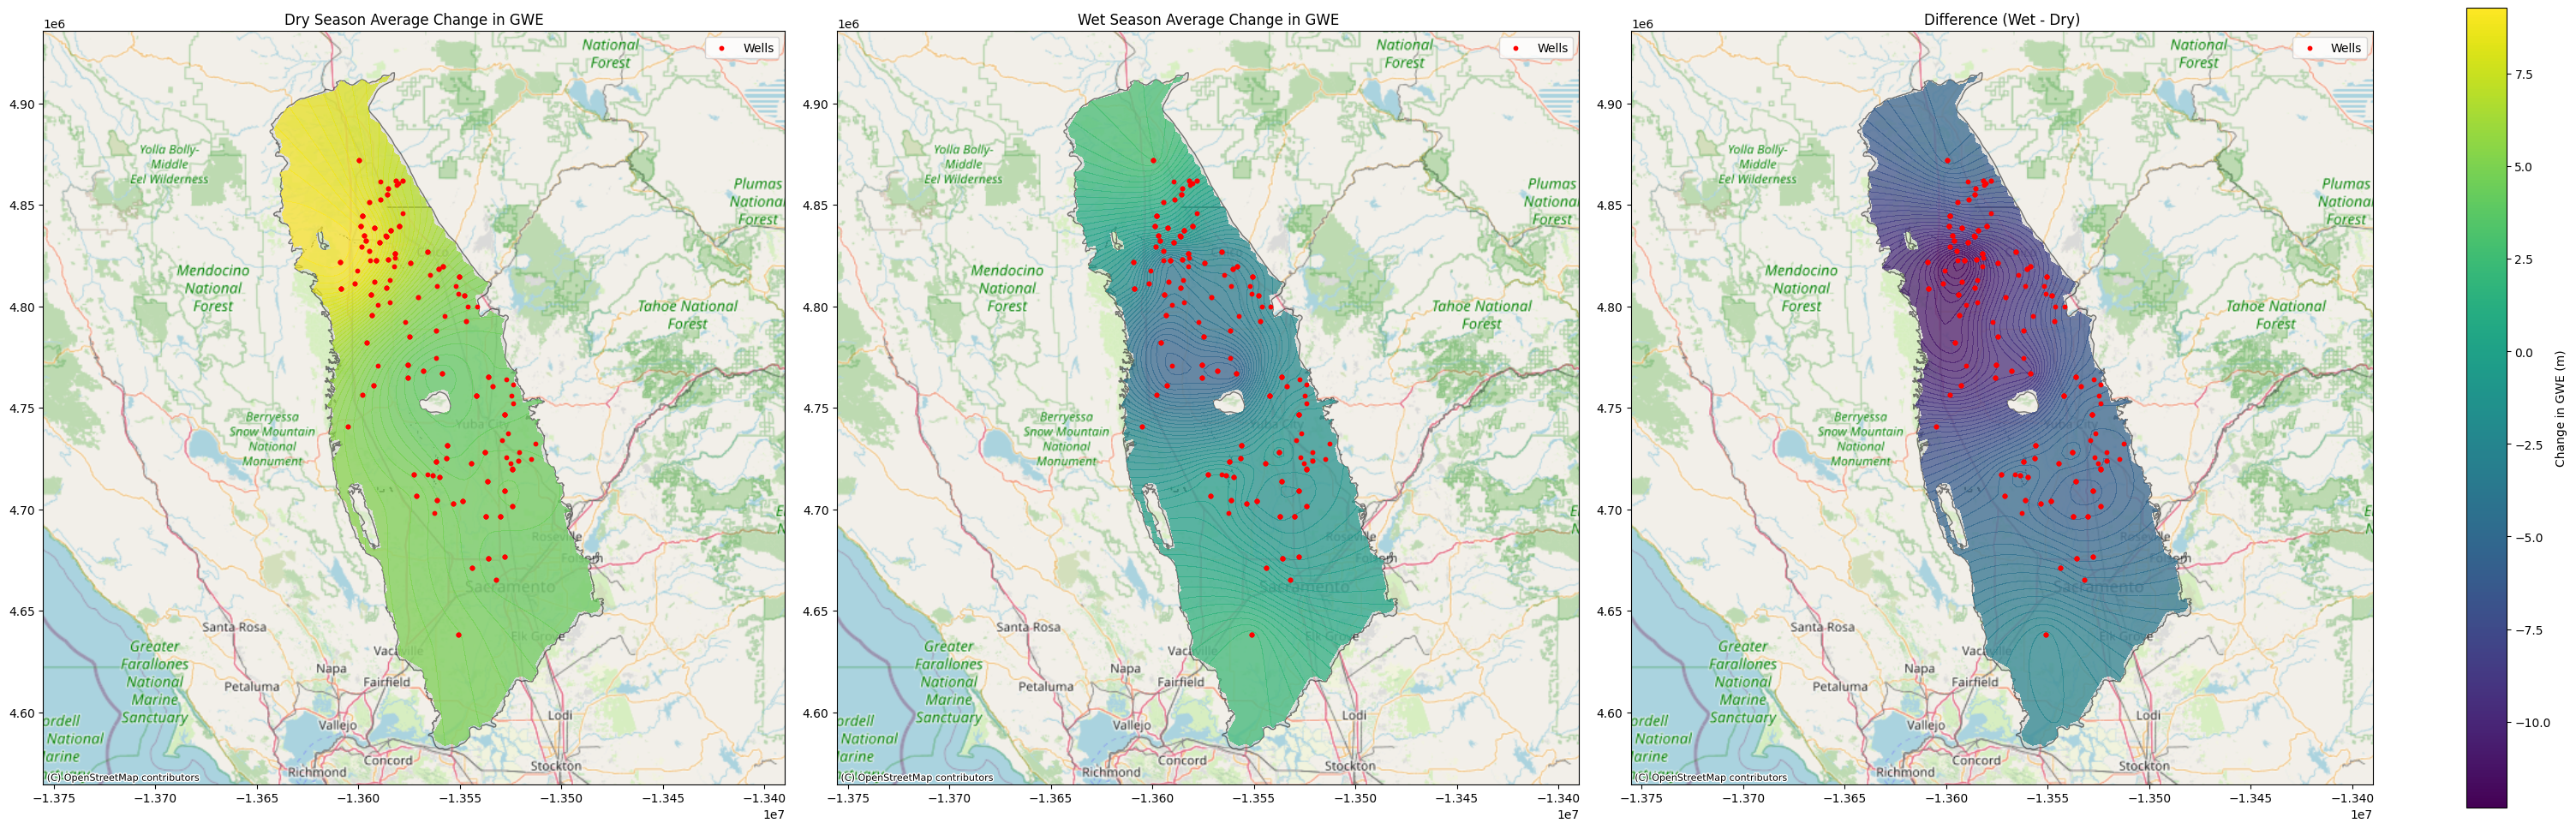

In [139]:
filtered_gdf = gdf[gdf['Basin_Numb'] == '5-021']
larger_polygon = filtered_gdf.dissolve().geometry.iloc[0]
larger_polygon_gdf = gpd.GeoDataFrame(
    geometry=[larger_polygon],
    crs=filtered_gdf.crs
)
larger_polygon_gdf = larger_polygon_gdf.to_crs(epsg=32633)
bounds = larger_polygon_gdf.total_bounds  # [minx, miny, maxx, maxy]

wells_gdf = gpd.GeoDataFrame(
    central_ov25_5021,
    geometry=gpd.points_from_xy(
        central_ov25_5021['longitude'], 
        central_ov25_5021['latitude']
    ),
    crs="EPSG:4326"
)

wells_gdf = wells_gdf.to_crs(larger_polygon_gdf.crs)

x = wells_gdf.geometry.x
y = wells_gdf.geometry.y
z_dry = wells_gdf['dry_avg_gwe']
z_wet = wells_gdf['wet_avg_gwe']

grid_x = np.linspace(bounds[0], bounds[2], num=100)
grid_y = np.linspace(bounds[1], bounds[3], num=100)

ok_dry = OrdinaryKriging(x, y, z_dry, variogram_model='linear')
z_interp_dry, ss_dry = ok_dry.execute('grid', grid_x, grid_y)

ok_wet = OrdinaryKriging(x, y, z_wet, variogram_model='linear')
z_interp_wet, ss_wet = ok_wet.execute('grid', grid_x, grid_y)

xx, yy = np.meshgrid(grid_x, grid_y)

grid_points = np.vstack((xx.flatten(), yy.flatten())).T
grid_points_gdf = gpd.GeoSeries(
    gpd.points_from_xy(grid_points[:, 0], grid_points[:, 1]),
    crs=larger_polygon_gdf.crs
)

mask = grid_points_gdf.within(larger_polygon_gdf.geometry.iloc[0])
mask = mask.values.reshape(xx.shape)

z_interp_masked_dry = np.ma.masked_where(~mask, z_interp_dry)
z_interp_masked_wet = np.ma.masked_where(~mask, z_interp_wet)

z_interp_diff = z_interp_wet - z_interp_dry
z_interp_masked_diff = np.ma.masked_where(~mask, z_interp_diff)

dry_vals = z_interp_masked_dry.compressed()
wet_vals = z_interp_masked_wet.compressed()
diff_vals = z_interp_masked_diff.compressed()

global_min = min(dry_vals.min(), wet_vals.min(), diff_vals.min())
global_max = max(dry_vals.max(), wet_vals.max(), diff_vals.max())

larger_polygon_3857 = larger_polygon_gdf.to_crs(epsg=3857)
wells_gdf_3857 = wells_gdf.to_crs(epsg=3857)

transformer = Transformer.from_crs("EPSG:32633", "EPSG:3857", always_xy=True)
xx_3857, yy_3857 = transformer.transform(xx, yy)

fig, (ax1, ax2, ax3) = plt.subplots(
    ncols=3, 
    figsize=(30, 10), 
    constrained_layout=True
)

norm = mpl.colors.Normalize(vmin=global_min, vmax=global_max)
cmap = 'viridis'

larger_polygon_3857.plot(ax=ax1, color='lightgray', edgecolor='black', alpha=0.5)
contour_dry = ax1.contourf(
    xx_3857, yy_3857,
    z_interp_masked_dry,
    levels=50,
    cmap=cmap,
    norm=norm,
    alpha=0.7
)
wells_gdf_3857.plot(ax=ax1, marker='o', color='red', markersize=10, label='Wells')
ax1.set_title('Dry Season Average Change in GWE')
ax1.set_aspect('equal')
ax1.legend()
ctx.add_basemap(ax1, crs=larger_polygon_3857.crs, source=ctx.providers.OpenStreetMap.Mapnik)

larger_polygon_3857.plot(ax=ax2, color='lightgray', edgecolor='black', alpha=0.5)
contour_wet = ax2.contourf(
    xx_3857, yy_3857,
    z_interp_masked_wet,
    levels=50,
    cmap=cmap,
    norm=norm,
    alpha=0.7
)
wells_gdf_3857.plot(ax=ax2, marker='o', color='red', markersize=10, label='Wells')
ax2.set_title('Wet Season Average Change in GWE')
ax2.set_aspect('equal')
ax2.legend()
ctx.add_basemap(ax2, crs=larger_polygon_3857.crs, source=ctx.providers.OpenStreetMap.Mapnik)

larger_polygon_3857.plot(ax=ax3, color='lightgray', edgecolor='black', alpha=0.5)
contour_diff = ax3.contourf(
    xx_3857, yy_3857,
    z_interp_masked_diff,
    levels=50,
    cmap=cmap,
    norm=norm,
    alpha=0.7
)
wells_gdf_3857.plot(ax=ax3, marker='o', color='red', markersize=10, label='Wells')
ax3.set_title('Difference (Wet - Dry)')
ax3.set_aspect('equal')
ax3.legend()
ctx.add_basemap(ax3, crs=larger_polygon_3857.crs, source=ctx.providers.OpenStreetMap.Mapnik)

sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(
    sm, 
    ax=[ax1, ax2, ax3],
    fraction=0.02, 
    pad=0.04
)
cbar.set_label("Change in GWE (m)")

plt.show()